# Loading modules

In [2]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

In [6]:
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import numpy as np
import pandas as pd
#Data visualisation
import matplotlib.pyplot as plt
#Spatial analysis
import geopandas as gp
import rasterio
from shapely.geometry import Point
from dask.distributed import Client

In [7]:
varDict = {'var_mod': 'aice_m',
           'var_short_name': 'SIC',
           'var_long_name': 'sea ice concentration',
           'model': 'ACCESS-OM2-01',
           'exp': '01deg_jra55v140_iaf_cycle4',
           'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
           'freq': '1 monthly',
           'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIce/SIC/Rasters_tiff'}

In [8]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39105,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:34707,Total threads: 3
Dashboard: /proxy/46813/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:41067,


In [9]:
session = cc.database.create_session()

In [10]:
#Loading data from fourth cycle (temporal range 1958 to 2018)
var_ice = uf.getACCESSdata_SO(varDict['var_mod'], '1978-01', '2019-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp'], ice_data = True)
#Loading data from fourth cycle extension (2019 to 2022)
var_ice_ext = uf.getACCESSdata_SO(varDict['var_mod'], '2019-01', '2023-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp_ext'], ice_data = True)

In [11]:
#Concatenating both data arrays into one
var_ice = xr.concat([var_ice, var_ice_ext], dim = 'time')
var_ice = uf.corrlong(var_ice)

#Removing duplicate variable
del var_ice_ext

In [12]:
#Adding CRS (WGS84)
var_ice.rio.write_crs('epsg:4326', inplace = True)
#Changing latitude and longitude names
var_ice = var_ice.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
var_ice

<xarray.DataArray 'aice_m' (time: 541, y: 740, x: 3600)>
dask.array<getitem, shape=(541, 740, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1977-12-31T12:00:00 ... 2022-12-31T12:...
  * x            (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * y            (y) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
    spatial_ref  int64 0
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [ ]:
os.makedirs(varDict['base_folder'], exist_ok = True)

for i, t in enumerate(var_ice.time):
    ds_t = var_ice.sel(time = t)
    date = np.datetime_as_string(t.values, unit = 'D')
    name_out = os.path.join(varDict['base_folder'], 
                            f'SeaIceConcentration_{date}.tif')
    ds_t.rio.to_raster(name_out)

In [10]:
x = pd.read_csv('../Cleaned_Data/All_sources_clean_data.csv')
x

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1.0,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10.0,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6.0,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6.0,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65.0,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
...,...,...,...,...,...,...,...,...,...,...
150609,2006-02-19T13:00:00Z,-67.0779,69.9942,1.0,HUMAN_OBSERVATION,2006,2,summer,moulting,2000
150610,2006-01-30T13:00:00Z,-67.9639,40.7485,1.0,HUMAN_OBSERVATION,2006,1,summer,moulting,2000
150611,2006-02-19T13:00:00Z,-67.0892,69.9950,2.0,HUMAN_OBSERVATION,2006,2,summer,moulting,2000
150612,2006-02-19T13:00:00Z,-67.1395,69.9984,1.0,HUMAN_OBSERVATION,2006,2,summer,moulting,2000


<AxesSubplot:>

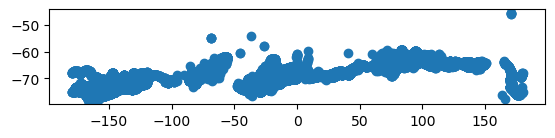

In [12]:
x = gp.GeoDataFrame(x, crs = 'epsg:4326', 
                geometry = gp.points_from_xy(x.longitude, x.latitude))
x.plot()

In [18]:
coord_list = [(x, y) for x, y in zip(x["geometry"].x, x["geometry"].y)]

In [26]:
base_folder = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'
bathy = xr.open_dataarray(os.path.join(base_folder, 'bathy_GEBCO_2D.nc'))
bathy

<xarray.DataArray 'depth' (yt_ocean: 740, xt_ocean: 3600)>
[2664000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:                   depth
    units:                       m
    minimum_depth:               10.43281
    minimum_levels:              7
    min_thick:                   1.0
    min_frac:                    0.2
    nonadvective_cells_removed:  yes
    lakes_removed:               yes

In [27]:
bathy.rio.write_crs('epsg:4326', inplace = True)
bathy

<xarray.DataArray 'depth' (yt_ocean: 740, xt_ocean: 3600)>
[2664000 values with dtype=float32]
Coordinates:
  * xt_ocean     (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean     (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.11 -45.04
    spatial_ref  int64 0
Attributes:
    long_name:                   depth
    units:                       m
    minimum_depth:               10.43281
    minimum_levels:              7
    min_thick:                   1.0
    min_frac:                    0.2
    nonadvective_cells_removed:  yes
    lakes_removed:               yes

<AxesSubplot:>

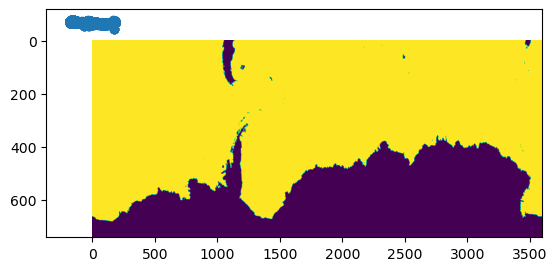

In [22]:
from rasterio.plot import show

fig, ax = plt.subplots()

ax = rasterio.plot.show(bathy, ax = ax)
x.plot(ax = ax)

In [30]:
bathy = bathy.rename({"xt_ocean": "longitude", "yt_ocean": "latitude"})

In [44]:
aff = bathy.rio.transform()
bound = bathy.rio.bounds()
bathy = bathy.rio.write_transform(aff, inplace=True)
bathy

<xarray.DataArray 'depth' (latitude: 740, longitude: 3600)>
[2664000 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude     (latitude) float64 -81.11 -81.07 -81.02 ... -45.11 -45.04
    spatial_ref  int64 0
Attributes:
    long_name:                   depth
    units:                       m
    minimum_depth:               10.43281
    minimum_levels:              7
    min_thick:                   1.0
    min_frac:                    0.2
    nonadvective_cells_removed:  yes
    lakes_removed:               yes

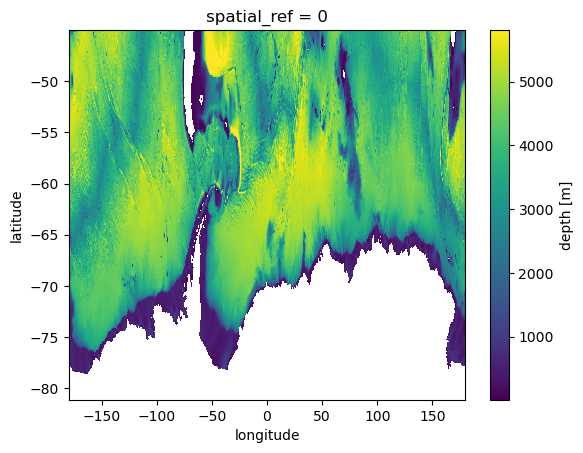

In [42]:
bathy.sa

In [45]:
x["value"] = [i for i in bathy.sample(coord_list)]
x.head()

AttributeError: 'DataArray' object has no attribute 'sample'